In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
sns.set(style="whitegrid")

In [34]:
file_path = "data/csv/results_augmented_threshold_0_6-0_8.csv"
df = pd.read_csv(file_path)

In [35]:
print("DataFrame Info:")
print(df.info())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086 entries, 0 to 1085
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ligand_id  1086 non-null   int64  
 1   conf_id    1086 non-null   int64  
 2   logp       1086 non-null   float64
 3   rmsd       956 non-null    float64
 4   energy     932 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 42.5 KB
None


In [36]:
df['ligand_id'] = df['ligand_id'].astype(str)
df['conf_id'] = pd.to_numeric(df['conf_id'], errors='coerce')
df['logp'] = pd.to_numeric(df['logp'], errors='coerce')
df['rmsd'] = pd.to_numeric(df['rmsd'], errors='coerce')
df['energy'] = pd.to_numeric(df['energy'], errors='coerce')

In [37]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
ligand_id      0
conf_id        0
logp           0
rmsd         130
energy       154
dtype: int64


In [38]:
df_clean = df.dropna(subset=['logp', 'rmsd', 'energy'])

In [39]:
base = df_clean[df_clean['conf_id'] == 0][['ligand_id', 'logp', 'energy']].rename(
    columns={'logp': 'base_logp', 'energy': 'base_energy'}
)

In [40]:
df_merged = df_clean.merge(base, on='ligand_id', how='left')


In [41]:
df_merged

,ligand_id,conf_id,logp,rmsd,energy,base_logp,base_energy
0,4020018,0,-1.948437,0.000000,445.863401,-1.948437,445.863401
1,4020018,1,-10.192733,0.575698,17542.608405,-1.948437,445.863401
2,4020018,2,-10.319717,0.579320,17889.277220,-1.948437,445.863401
3,4020018,3,-10.234915,0.581168,18122.875446,-1.948437,445.863401
4,4020018,4,-10.155535,0.583058,18329.922014,-1.948437,445.863401
...,...,...,...,...,...,...,...
827,4029064,6,-14.557611,0.637662,13780.545290,-5.063432,249.789758
828,4029064,7,-13.094853,0.651806,13242.413513,-5.063432,249.789758
829,4029064,8,-13.249487,0.654642,13145.990767,-5.063432,249.789758
830,4029064,9,-13.412560,0.670024,13597.120723,-5.063432,249.789758


In [42]:
df_merged['delta_logp'] = df_merged['logp'] - df_merged['base_logp']
df_merged['delta_energy'] = df_merged['energy'] - df_merged['base_energy']

In [43]:
df_diffs = df_merged[df_merged['conf_id'] != 0]

In [44]:
df['logp_rank'] = df.groupby('ligand_id')['logp'].rank(ascending=False,method='min')
df['energy_rank'] = df.groupby('ligand_id')['energy'].rank(method='min')


In [45]:
def extract_base_ranks(group):
    base = group[group['conf_id'] == 0]
    if base.empty:
        return pd.Series({col: None for col in [
            'logp_rank_base', 'energy_rank_base',
            'logp_top_1', 'logp_top_3', 'logp_top_5',
            'energy_top_1', 'energy_top_3', 'energy_top_5'
        ]})
    
    logp_rank = base['logp_rank'].values[0]
    energy_rank = base['energy_rank'].values[0]
    
    return pd.Series({
        'logp_rank_base': logp_rank,
        'energy_rank_base': energy_rank,
        'logp_top_1': logp_rank == 1,
        'logp_top_3': logp_rank <= 3,
        'logp_top_5': logp_rank <= 5,
        'energy_top_1': energy_rank == 1,
        'energy_top_3': energy_rank <= 3,
        'energy_top_5': energy_rank <= 5
    })


In [46]:
rank_summary = df.groupby('ligand_id').apply(extract_base_ranks).reset_index()



In [47]:
accuracy = rank_summary[
    ['logp_top_1', 'logp_top_3', 'logp_top_5', 'energy_top_1', 'energy_top_3', 'energy_top_5']
].mean()
print("Prediction Accuracy (Fraction of Ligands):")
print(accuracy)



Prediction Accuracy (Fraction of Ligands):
logp_top_1      0.868687
logp_top_3      0.868687
logp_top_5      0.868687
energy_top_1    0.858586
energy_top_3    0.858586
energy_top_5    0.858586
dtype: float64


In [48]:
plot_df = accuracy.reset_index()
plot_df.columns = ['metric', 'fraction']
plot_df['method'] = plot_df['metric'].apply(lambda x: 'logP' if 'logp' in x else 'energy')
plot_df['rank_cutoff'] = plot_df['metric'].str.extract(r'top_(\d)').astype(int)


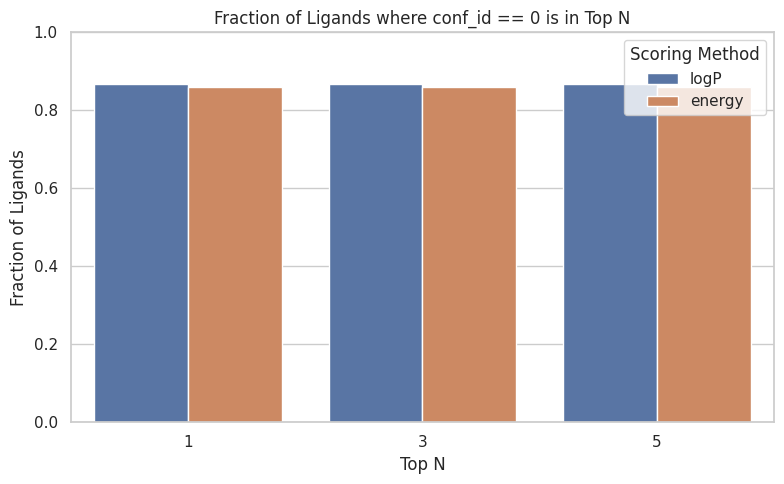

In [49]:
plt.figure(figsize=(8, 5))
sns.barplot(data=plot_df, x='rank_cutoff', y='fraction', hue='method')
plt.title("Fraction of Ligands where conf_id == 0 is in Top N")
plt.ylabel("Fraction of Ligands")
plt.xlabel("Top N")
plt.ylim(0, 1)
plt.legend(title="Scoring Method")
plt.tight_layout()
plt.show()

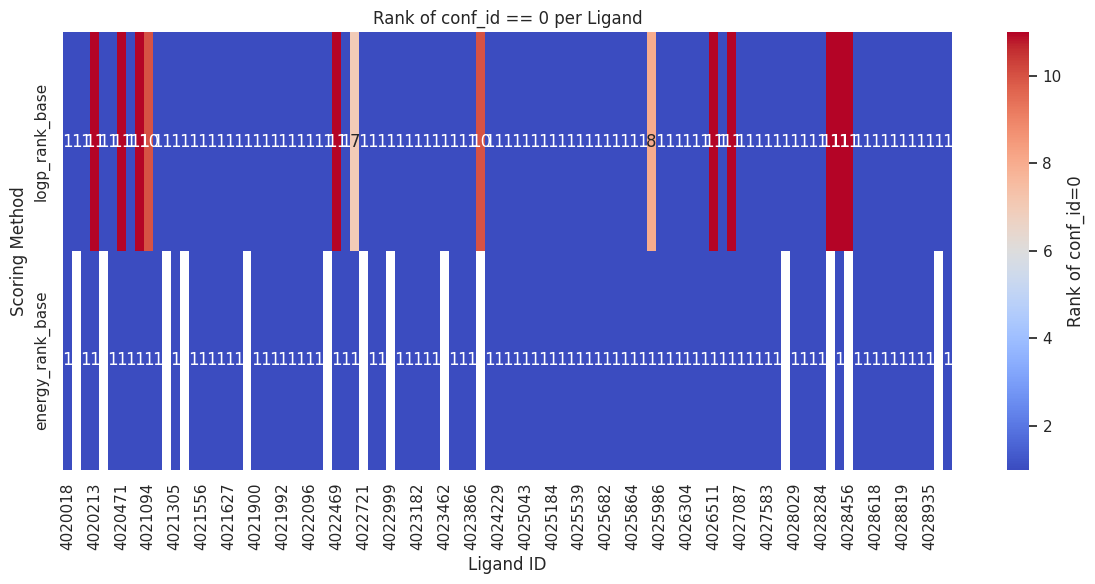

In [50]:
pivot = rank_summary[['ligand_id', 'logp_rank_base', 'energy_rank_base']].set_index('ligand_id')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot.T, annot=True, cmap="coolwarm", cbar_kws={'label': 'Rank of conf_id=0'})
plt.title("Rank of conf_id == 0 per Ligand")
plt.xlabel("Ligand ID")
plt.ylabel("Scoring Method")
plt.tight_layout()
plt.show()

In [51]:
import os
import subprocess

def get_atom_count_from_cif_obabel(cif_path):
    try:
        result = subprocess.run(
            ["obabel", "-icif", cif_path, "-osmi"],
            capture_output=True, text=True, check=True
        )
        smiles = result.stdout.strip()
        if smiles:
            atom_count = sum(1 for c in smiles if c.isalpha() and c.isupper())
            return atom_count
        else:
            raise ValueError("No SMILES generated")
    except subprocess.CalledProcessError as e:
        print(f"Open Babel error on {cif_path}: {e.stderr}")
        return None
    except Exception as e:
        print(f"General error on {cif_path}: {e}")
        return None


In [52]:
# import pandas as pd

# cif_dir = "data/cif"
# entries = []

# for filename in os.listdir(cif_dir):
#     if filename.endswith(".cif"):
#         ligand_id = os.path.splitext(filename)[0]
#         cif_path = os.path.join(cif_dir, filename)
#         atom_count = get_atom_count_from_cif_obabel(cif_path)
#         entries.append({'ligand_id': ligand_id, 'atom_count': atom_count})

# size_df = pd.DataFrame(entries)
# size_df = size_df.dropna(subset=['atom_count'])
# size_df.to_csv("ligand_sizes.csv", index=False)
# print("Saved ligand_sizes.csv")


In [53]:
df['logp_rank'] = df.groupby('ligand_id')['logp'].rank(ascending=False, method='min')
df['energy_rank'] = df.groupby('ligand_id')['energy'].rank(ascending=True, method='min')


In [54]:
n_confs = df.groupby('ligand_id')['conf_id'].count().rename('n_confs')


In [55]:
base_ranks = df[df['conf_id'] == 0][['ligand_id', 'logp_rank', 'energy_rank']].set_index('ligand_id')
base_ranks = base_ranks.join(n_confs)


In [56]:
base_ranks['logp_rank_norm'] = (base_ranks['logp_rank'] - 1) / (base_ranks['n_confs'] - 1)
base_ranks['energy_rank_norm'] = (base_ranks['energy_rank'] - 1) / (base_ranks['n_confs'] - 1)



In [57]:
# Load ligand sizes from CSV
ligand_sizes = pd.read_csv("ligand_sizes.csv")  # contains 'ligand_id', 'atom_count'

ligand_sizes['ligand_id'] = ligand_sizes['ligand_id'].astype(str)

# Merge into base_ranks
base_ranks = base_ranks.reset_index().merge(ligand_sizes, on='ligand_id', how='left')

# Drop entries where size is missing
base_ranks = base_ranks.dropna(subset=['atom_count'])

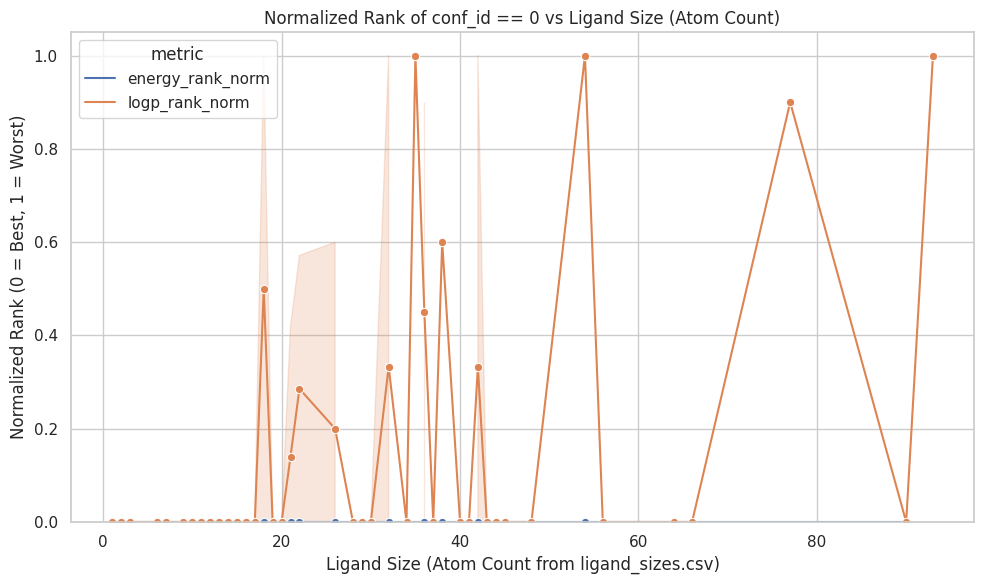

In [58]:
melted = base_ranks[['ligand_id', 'atom_count', 'logp_rank_norm', 'energy_rank_norm']] \
    .melt(id_vars=['ligand_id', 'atom_count'],
          value_vars=['logp_rank_norm', 'energy_rank_norm'],
          var_name='metric', value_name='norm_rank')

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=melted.sort_values('atom_count'), x='atom_count', y='norm_rank', hue='metric', marker='o')

plt.title("Normalized Rank of conf_id == 0 vs Ligand Size (Atom Count)")
plt.xlabel("Ligand Size (Atom Count from ligand_sizes.csv)")
plt.ylabel("Normalized Rank (0 = Best, 1 = Worst)")
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
not_best_ligands = base_ranks[base_ranks['energy_rank'] != 1]['ligand_id'].tolist()

# Get all conformers for those ligands
bad_base_confs = df[df['ligand_id'].isin(not_best_ligands)]

# Optional: only show conf_id == 0 from those
bad_conf0 = bad_base_confs[bad_base_confs['conf_id'] == 0]

# Save or print
bad_conf0[['ligand_id', 'conf_id', 'logp_rank', 'energy_rank']]

,ligand_id,conf_id,logp_rank,energy_rank
11,4020157,0,1.0,NaN
44,4020399,0,1.0,NaN
121,4021229,0,1.0,NaN
143,4021502,0,1.0,NaN
220,4021816,0,1.0,NaN
318,4022234,0,1.0,NaN
362,4022721,0,1.0,NaN
395,4022999,0,1.0,NaN
461,4023462,0,1.0,NaN
505,4023967,0,10.0,NaN
